# Telco Churn Project
Jamaal Smith



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

## Data Import and Cleaning

### First Impressions of Data

In [13]:
#import the data
df = pd.read_csv('churn_data.csv')

from scrubbing import info
info(df)

(state                      object
 account length              int64
 area code                   int64
 phone number               object
 international plan         object
 voice mail plan            object
 number vmail messages       int64
 total day minutes         float64
 total day calls             int64
 total day charge          float64
 total eve minutes         float64
 total eve calls             int64
 total eve charge          float64
 total night minutes       float64
 total night calls           int64
 total night charge        float64
 total intl minutes        float64
 total intl calls            int64
 total intl charge         float64
 customer service calls      int64
 churn                        bool
 dtype: object, (3333, 21))

Based on initial review of the data, we can conclude that the dataset is comprised of 21 columns and 3333 rows. Further, there are no null values in the data set.

The next step in preparing the data for the model is to convert the object type in the phone number, international plan, and voicemail plan columns for the machine learning model.

For now, I will only focus on the international and voicemail plan columns. I made this decision because the phone number a person is assigned plays no role in whether or not a person keeps their service.

In [14]:
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

### Voicemail and International Plan treatment

In these two columns, the number 1 signifies yes and 0 signifies no

In [15]:
key = {'yes':1, 'no':0}
df['international plan']=df['international plan'].map(key)
df['voice mail plan'] = df['voice mail plan'].map(key)

df['international plan'].astype(str).astype(float)
df['voice mail plan'].astype(str).astype(float)

0       1.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
3328    1.0
3329    0.0
3330    0.0
3331    0.0
3332    1.0
Name: voice mail plan, Length: 3333, dtype: float64

As noted before, since it is hard to argue that a given phone number has any relation to churn rate, this column will be eliminated now as part of the feature selection process.

In [16]:
df_final = df.drop('phone number', axis = 1)

### Treatment of Churn Column

In [17]:
df_final['churn'] = df_final['churn']*1
df_final['churn']

0       0
1       0
2       0
3       0
4       0
       ..
3328    0
3329    0
3330    0
3331    0
3332    0
Name: churn, Length: 3333, dtype: int64

### Treatment of State Column

In [18]:
#display(df_final['state'].value_counts())
df_final = df_final.drop('state',axis=1)
df_final.shape

(3333, 19)

At first, I didn't think that state would have any predictive value in the model. However, by using groupby, I was able to organize the dataset by the mean of all explanatory variables for a particular state. This can also ease future calculations because instead of 3000+ rows, the models will only have 51.

This thought was later reversed when treating for outliers. To prevent overfit of the model and knowing that the state isn't an important feature as measured by the chi-squared score later, we will drop the state column

### Outlier treatment

In [19]:
from scrubbing import outliers
outliers(df_final)

(2860, 19)

### Assigning Data and Target Variables

## Data Distribution Visualization

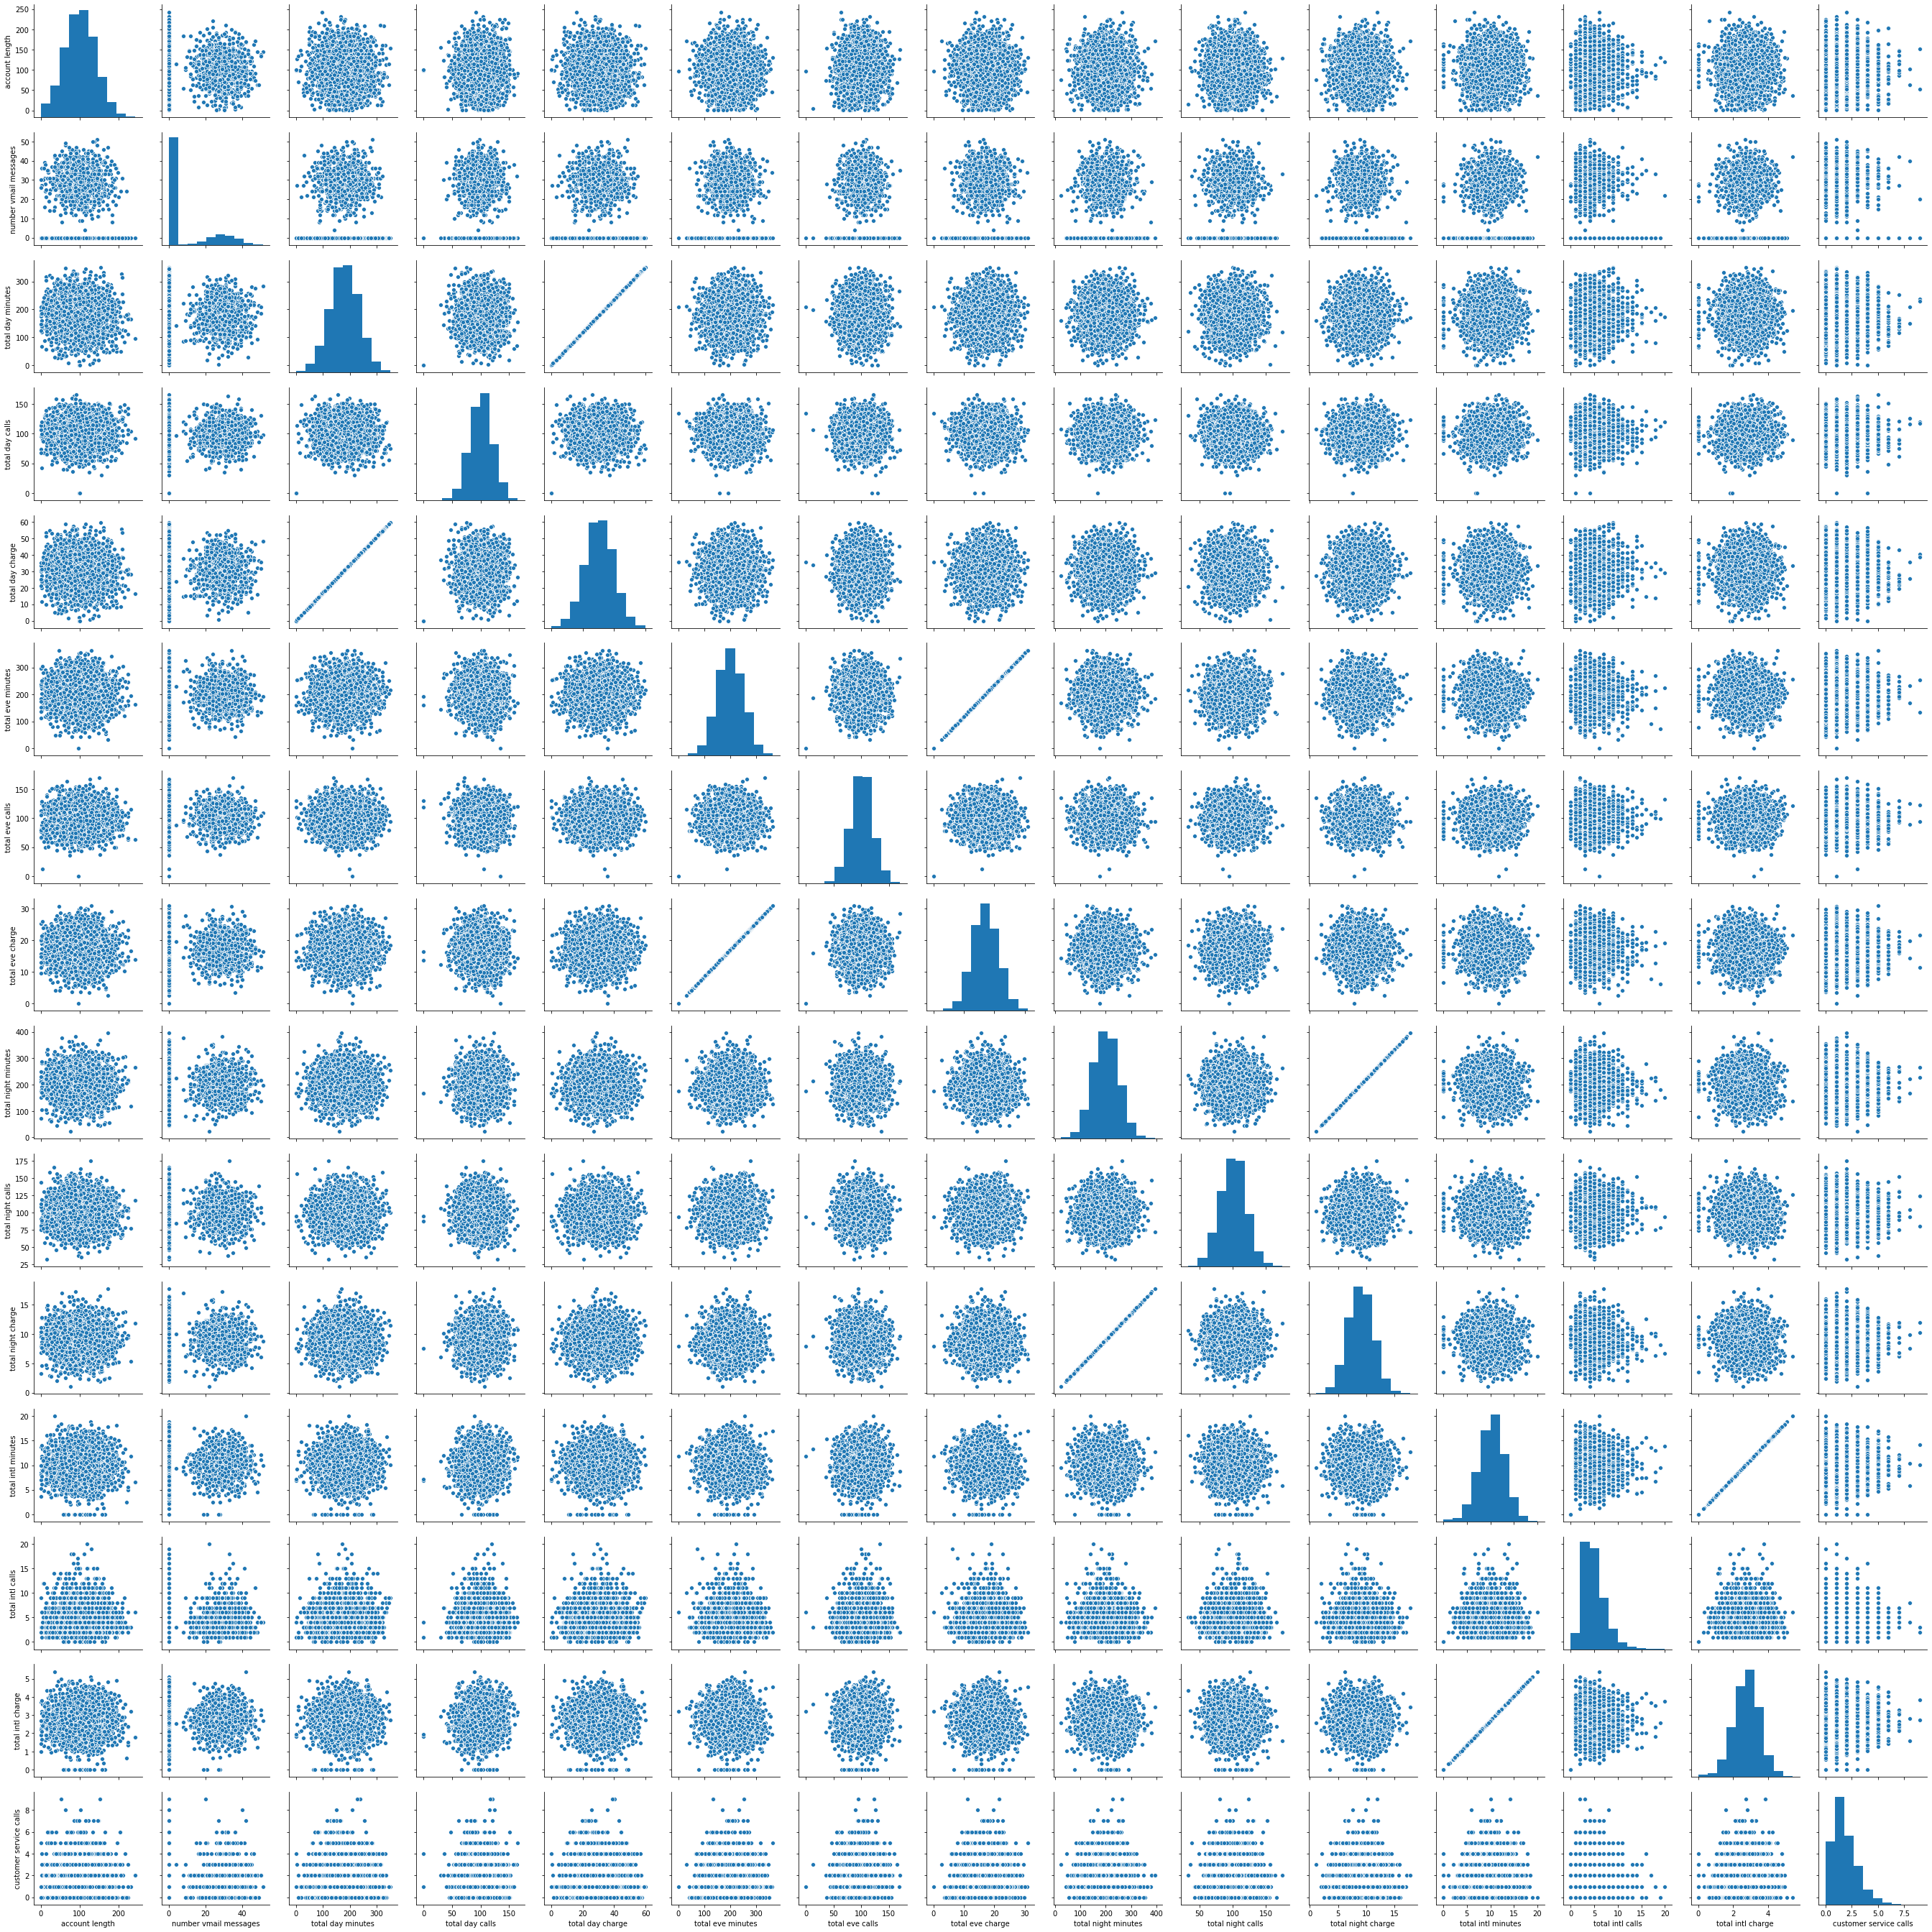

In [21]:
#removed boolean columns to avoid errors and they wouldn't be of much use
import seaborn as sns
data = df_final.drop(columns= ['international plan', 'voice mail plan','area code','churn'])
sns.pairplot(data)
plt.show()

Based on the pairplot shown above, most of the data appears to be normally distributed without any noticeable outliers. Still, to ensure ideal model performance, we will remove any outliers (z-score of 3) from the data.

##Assigning the independent and dependent variabls

In [22]:
X = data
y = df_final['churn']

The pairplot graph highlights that all of the non-boolean dataframes are somewhat normally distributed. To optimize later model performance, data will be standardized and outliers treated. Again, the above visualization suggests that the data should only endure minor adjustments.

Of all the datasets, the number of voicemail data appears to have lots of 0s in its distribution.

For now, the states column will be left in the dataset and later feature selection measures will provide a statistically significant method for determining whether or not this explanatory variable will be included in the final model.

### Splitting Data into Training and Test Data Sets

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Feature Scaling

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Machine Learning Models

## Random Tree Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
y_predRFC = RFC.predict(X_test)

### Random Forest Classifier Evaluation

The Accuracy Score for this model is 0.9130434782608695


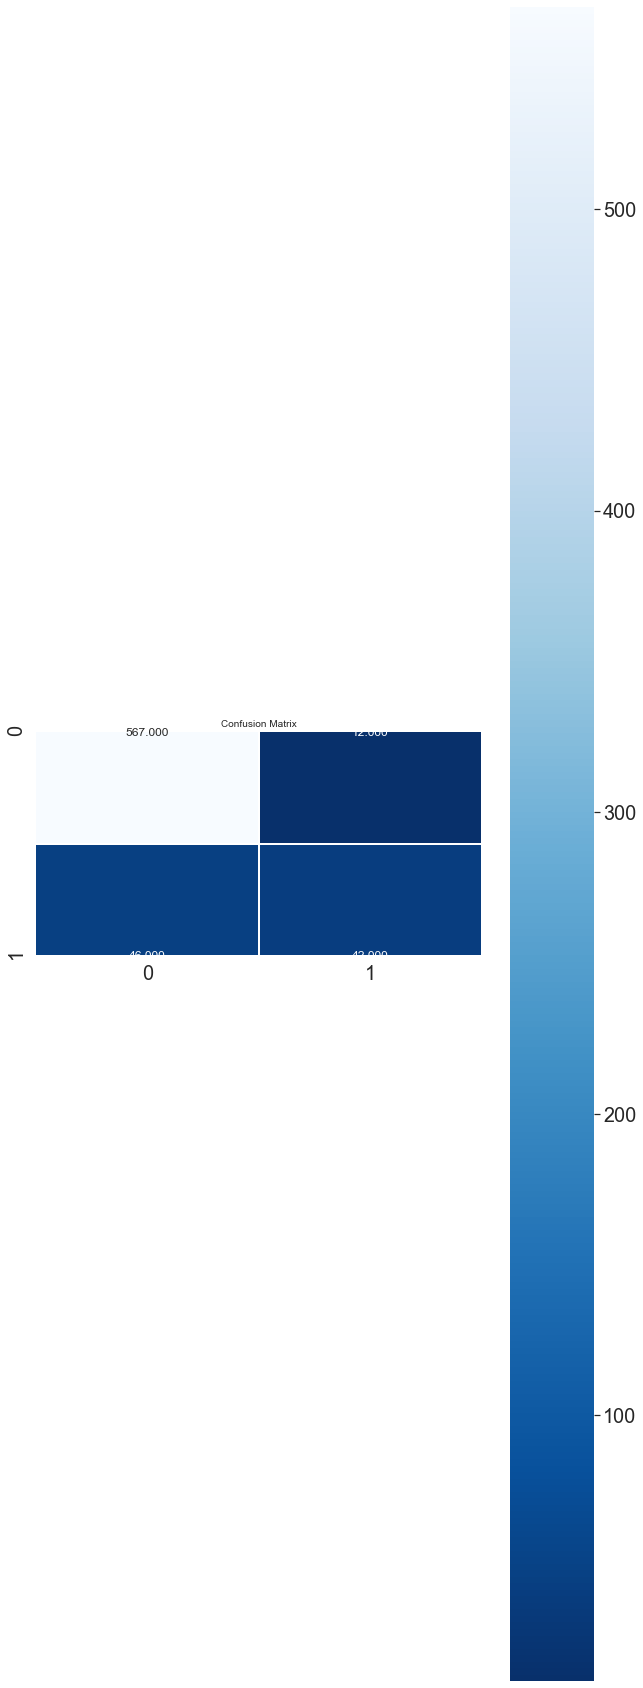

In [39]:
from scrubbing import results
results(y_test,y_predRFC)


### Classification Report

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predRFC))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       579
           1       0.78      0.48      0.59        88

    accuracy                           0.91       667
   macro avg       0.85      0.73      0.77       667
weighted avg       0.91      0.91      0.90       667



### Random Forest Feature Selection

In [51]:
from scrubbing import bestinputs
bestinputs(X_train,y_train)

TypeError: __init__() got an unexpected keyword argument 'prefit'

### Adjusting Data Set for top three features

In [52]:
X = df_final.iloc[:,[2,4,14]].values
y = df_final.iloc[:, -1].values


(3333, 3)

### Data Split

In [44]:
from sklearn.model_selection import train_test_split
X_trainfeat, X_testfeat, y_trainfeat, y_testfeat = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Random Forest Classifer with Three Features

In [45]:
from sklearn.ensemble import RandomForestClassifier
RFC_Feature = RandomForestClassifier()
RFC_Feature.fit(X_trainfeat,y_trainfeat)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
y_predRFC_Feature = RFC_Feature.predict(X_testfeat)

The Accuracy Score for this model is 0.8725637181409296


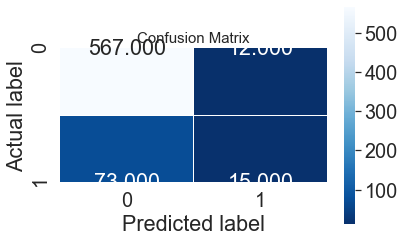

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_testfeat,y_predRFC_Feature)
acc = accuracy_score(y_testfeat,y_predRFC_Feature)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15);


### Random Forest Classifier with Feature Selection Report

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_testfeat,y_predRFC_Feature))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       579
           1       0.56      0.17      0.26        88

    accuracy                           0.87       667
   macro avg       0.72      0.57      0.60       667
weighted avg       0.84      0.87      0.84       667



### Random Forest Desicion Tree For All Features

In [49]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

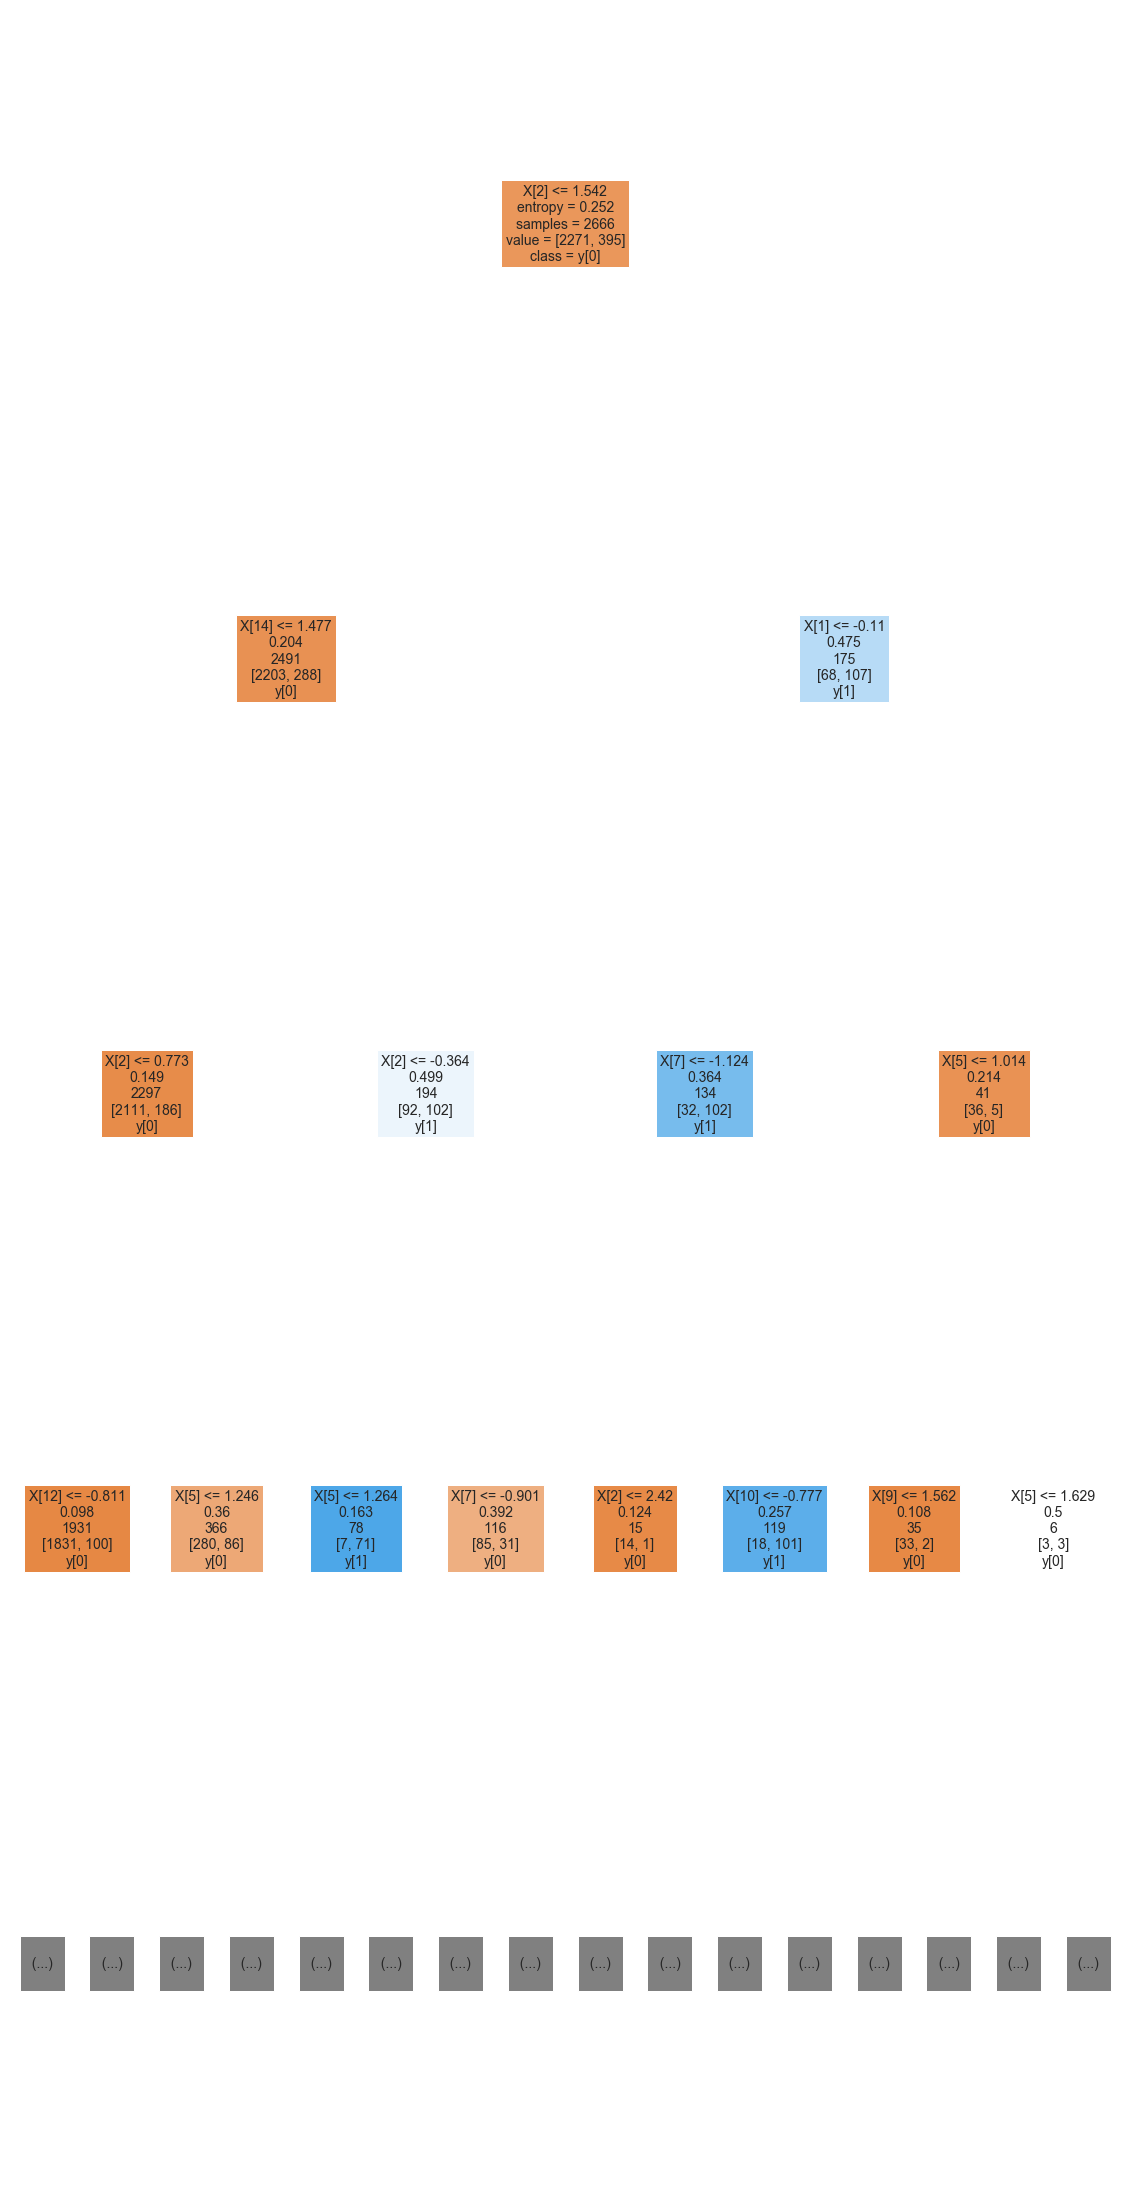

In [50]:
plt.figure(figsize=(20,40))
a = tree.plot_tree(clf,max_depth = 3,label = 'root',rotate=True,fontsize= 14, class_names=True,filled=True)

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
logclassifer = LogisticRegression()
logclassifer.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = logclassifer.predict(X_test)

The Accuracy Score for this model is 0.8680659670164917


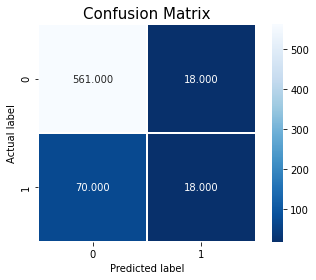

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15);


###Logistic Regression Classifiction Report


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       579
           1       0.50      0.20      0.29        88

    accuracy                           0.87       667
   macro avg       0.69      0.59      0.61       667
weighted avg       0.84      0.87      0.84       667



###Recursive Feature Elimination

In [0]:
from sklearn.feature_selection import RFE
estimator = LogisticRegression()
selector = RFE(estimator,1,step=1)
selector = selector.fit(X_train,y_train)
selector.ranking_

array([13, 16,  3,  4,  5,  6, 15,  1, 11, 17,  7,  8, 18, 12, 14, 10,  9,
        2])

###Model Performance with Feature Elimanation

The Accuracy Score for this model is 0.8710644677661169


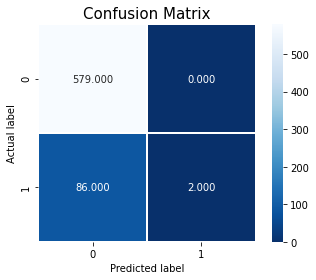

In [0]:
y_predfeature = selector.predict(X_test)
cm = confusion_matrix(y_test,y_predfeature)
acc = accuracy_score(y_test,y_predfeature)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {acc}'.format(acc = acc)
plt.title('Confusion Matrix', size = 15);

###Logistic Regression with Feature Elimination Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predfeature))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       579
           1       1.00      0.02      0.04        88

    accuracy                           0.87       667
   macro avg       0.94      0.51      0.49       667
weighted avg       0.89      0.87      0.81       667



## Support Vector Machine Regression

In [54]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [55]:
y_predSVM = classifier.predict(X_test)

The Accuracy Score for this model is 0.9190404797601199


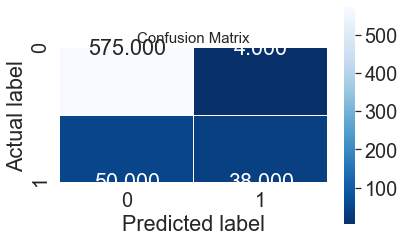

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_predSVM)
acc = accuracy_score(y_test,y_predSVM)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15);


### SVM Classification Report

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predSVM))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       579
           1       0.90      0.43      0.58        88

    accuracy                           0.92       667
   macro avg       0.91      0.71      0.77       667
weighted avg       0.92      0.92      0.91       667



### Feature Selection for SVM with linear penalizer

In [60]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
LSVC = LinearSVC(C=0.01, penalty='l1', dual=False).fit(X_train,y_train)
model = SelectFromModel(LSVC,prefit=True)
y_predfeatureSVM = LSVC.predict(X_test) 

### Model Performance of SVM with Linear Penalizer Feature Selection

The Accuracy Score for this model is 0.8695652173913043


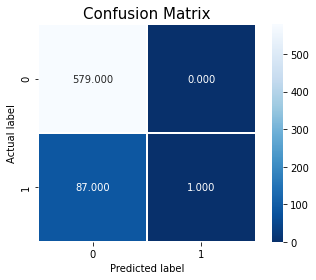

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test,y_predfeatureSVM)
acc = accuracy_score(y_test,y_predfeatureSVM)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15);

### Support Vector Machine with Feature Elimination Classification Report

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predfeatureSVM))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       579
           1       1.00      0.01      0.02        88

    accuracy                           0.87       667
   macro avg       0.93      0.51      0.48       667
weighted avg       0.89      0.87      0.81       667



### Support Vector Machine with Three Features

In [62]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_trainfeat, y_trainfeat)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [63]:
y_predSVC3 = classifier.predict(X_testfeat)

The Accuracy Score for this model is 0.8800599700149925


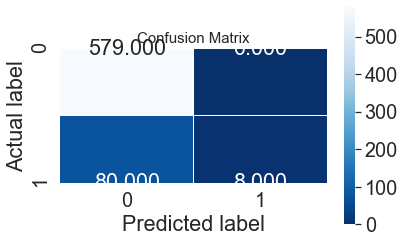

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_testfeat,y_predSVC3)
acc = accuracy_score(y_testfeat,y_predSVC3)
print('The Accuracy Score for this model is {acc}'.format(acc=acc))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title('Confusion Matrix', size = 15);

### Support Vector Machine with Three Feature Classification Report

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_testfeat,y_predSVC3))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       579
           1       1.00      0.09      0.17        88

    accuracy                           0.88       667
   macro avg       0.94      0.55      0.55       667
weighted avg       0.89      0.88      0.83       667



## SHAP Visualizations

In [0]:
pip install shap

     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394129 sha256=c2d533c8b75db110b4152a89d647a11eeab96103ede18272ed7b85d475eb9ea4
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


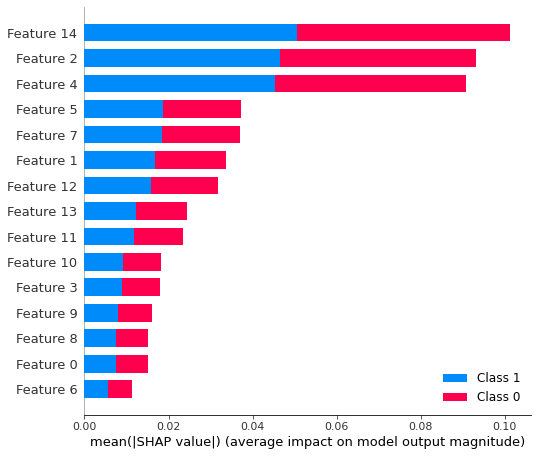

In [0]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(RFC,check_additivity=False)
shap_values = explainer.shap_values(X_train, check_additivity=False)
shap.summary_plot(shap_values,X_train)

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)